In [7]:
import math

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import HTML

from matk.utils.animation import animate_frames

%matplotlib inline

In [2]:
import math

from typing import Tuple

import numpy as np

from matk.models.base_model import _BaseModel
from matk.utils.geometry import angle_between_points


def coord_to_from_point(position, distination, step_size, clipping, to=True):
    angle = angle_between_points(position, distination) 
    abs_angle = np.clip(abs(angle), 0, clipping)
    if angle < 0:
        angle = -abs_angle
    else:
        angle = abs_angle
    rad = math.radians(angle)
    dx = math.cos(rad) * step_size
    dy = math.sin(rad) * step_size
    if not to:
        dx = -dx
        dy = -dy
    else:
        if np.abs(position - distination).max() < 0.5:
            return 0, 0
        
    return dx, dy

class FlockingModel(_BaseModel):
    def __init__(
        self,
        n_points: int,
        field_size: Tuple[int, int],
        step_size: int,
        view: float = 5,
        minimum_separation: float = 20,
        max_align_turn: float = 30,
        max_cohere_turn: float = 20,
        max_separate_turn: float = 10
    ):
        super().__init__(
            n_points=n_points,
            field_size=field_size,
            step_size=step_size,
            keep_trajoctories=False,
        )
        self.view = view
        self.minimum_separation = minimum_separation
        self.max_align_turn = max_align_turn
        self.max_cohere_turn = max_cohere_turn
        self.max_separate_turn = max_separate_turn
        
        self.points = []
        self.is_placed = []
        self.flocks = []

    def create_field(self):
        point_coords = [
            np.random.randint(0, f_size, self.n_points)
            for f_size in self.field_size
        ]
        point_coords = np.stack(point_coords, axis=-1).astype(float)

        self.find_flocks(point_coords)
        self.points.append(point_coords)
        self.markup_field(point_coords)
        
    def compute_step_to_flockmate_heading(self, current_coord, coords):
        distances = np.linalg.norm( coords - current_coord[None, :], axis=-1)
        flock = coords[distances < self.view]
        if len(flock) < 2:
            return current_coord
        head = flock.mean(0)
        dx, dy = coord_to_from_point(
            current_coord, 
            head, 
            self.step_size,
            self.max_align_turn
        )
        current_coord[0] += dx
        current_coord[1] += dy
        return current_coord
    
    def compute_step_out_of_neighbour(self, current_coord, neighbour_coord):
        dx, dy = coord_to_from_point(
            current_coord, 
            neighbour_coord, 
            self.step_size, 
            self.max_separate_turn,
            to=False
        )
        current_coord[0] += dx
        current_coord[1] += dy
            
        return current_coord
    
    def compute_step_to_neighbour(self, current_coord, neighbour_coord):
        dx, dy = coord_to_from_point(
            current_coord, 
            neighbour_coord, 
            self.step_size, 
            self.max_cohere_turn
        )
        current_coord[0] += dx
        current_coord[1] += dy
            
        return current_coord
    
    def compute_dist_to_nearby(self, current_coord, current_coord_id, coords):
        all_p_exclude_current = np.delete(coords, current_coord_id, 0) 
        distances = np.linalg.norm( all_p_exclude_current - current_coord[None, :], axis=-1)
        argmin_dist = np.argmin(distances)
        nearest_point = all_p_exclude_current[argmin_dist]
        smallest_dist = distances[argmin_dist]
        return smallest_dist, nearest_point
    
    def find_flocks(self, coords):
        all_flocks = []
        
        for i in range(coords.shape[0]):
            point = coords[i]
            distances = np.linalg.norm( coords - point[None, :], axis=-1)
            flock_indices = np.where(distances < self.view)[0]
            if i == 0 or np.all([not np.array_equal(flock_indices, el) for el in all_flocks]):
                all_flocks.append(flock_indices)
            
        self.flocks.append(all_flocks)

    def step(self):
        current_coords = self.points[-1].copy()
        new_coords = np.zeros_like(current_coords)

        for i in range(current_coords.shape[0]):
            current_point = current_coords[i]
            smallest_dist, nearest_point = self.compute_dist_to_nearby(
                current_point,
                i,
                current_coords
            )
            if smallest_dist < self.minimum_separation:
                new_point = self.compute_step_out_of_neighbour(current_point, nearest_point)
                new_point = self.continious_boarder_mode(new_point)
            else:
                new_point = self.compute_step_to_flockmate_heading(current_point, current_coords)
                new_point = self.continious_boarder_mode(new_point)
                _, nearest_point = self.compute_dist_to_nearby(
                    new_point,
                    i,
                    current_coords
                )
                new_point = self.compute_step_to_neighbour(new_point, nearest_point)
                new_point = self.continious_boarder_mode(new_point)
                
            new_coords[i] = new_point
           
        self.find_flocks(new_coords)
        self.points.append(new_coords)
        self.markup_field(new_coords)

    def reset_partial(self):
        self.points = []
        self.stop = False


In [3]:
def subtract_headings(a, b):
    diff = a - b
    diff  = (diff + 180) % 360 - 180
    if diff == -180: return 180
    return diff

subtract_headings(180, 0)

180

In [ ]:
import math

from typing import Tuple

import numpy as np

from matk.models.base_model import _BaseModel
from matk.utils.geometry import angle_between_points

class NetlogoFlockingModel(_BaseModel):
    def __init__(
        self,
        n_points: int,
        field_size: Tuple[int, int],
        step_size: int,
        view: float = 5,
        minimum_separation: float = 20,
        max_align_turn: float = 30,
        max_cohere_turn: float = 20,
        max_separate_turn: float = 10
    ):
        super().__init__(
            n_points=n_points,
            field_size=field_size,
            step_size=step_size,
            keep_trajoctories=False,
        )
        self.view = view
        self.minimum_separation = minimum_separation
        self.max_align_turn = max_align_turn
        self.max_cohere_turn = max_cohere_turn
        self.max_separate_turn = max_separate_turn
        
        self.points = []
        #self.flocks = []

    def create_field(self):
        point_coords = [
            np.random.randint(0, f_size, self.n_points)
            for f_size in self.field_size
        ]
        point_coords += [np.random.uniform(low=-180, high=180, size=self.n_points)]
        point_coords = np.stack(point_coords, axis=-1).astype(float)

        self.points.append(point_coords)
        self.markup_field(point_coords)
        
    def find_flockmates(self, point, point_id, coords):
        all_p_exclude_current = np.delete(coords, point_id, 0) 
        distances = np.linalg.norm( all_p_exclude_current[:,:-1] - point[None, :-1], axis=-1)
        return all_p_exclude_current[distances < self.view]  
    
    def find_nearest_neighbor(self, point, coords):
        distances = np.linalg.norm( coords - point[None, :], axis=-1)
        nearest_point = coords[np.argmin(distances)]
        distance = np.min(distances)
        return nearest_point, distance
    
    def avarage_flockmate_heading(self, flockmates, point):
        dx = np.cos(flockmates[:,-1]).sum()
        dy = np.sin(flockmates[:,-1]).sum()
        if dx == 0 and dy == 0:
            return point[-1]
        else:
            return math.atan2(dy ,dx)
    
    def turn_at_most(self, angle, max_angle):
        print(angle)
        if abs(angle) > max_angle:
            if angle > 0:
                return max_angle
            else:
                return - max_angle
        else:
            return angle
    
    def turn_away(self, coord, angle, max_angle):
        turn = self.turn_at_most(
            subtract_headings(coord[-1], angle), 
            max_angle
        )
        coord[-1] = coord[-1] + turn
        coord = self.rt(coord)
        
        return coord
    
    def turn_towards(self, coord, angle, max_angle):
        turn = self.turn_at_most(
            subtract_headings(angle, coord[-1]), 
            max_angle
        )
        coord[-1] = coord[-1] + turn
        coord = self.rt(coord)
        return coord
        
    def separate(self, point, separate_point):
        angle = separate_point[-1]
        current_coord = self.turn_away(point, angle, self.max_separate_turn)
            
        return current_coord
    
    def align(self, point, flockmates):
        avarage_flockmate_heading = self.avarage_flockmate_heading(flockmates, point)
        return self.turn_towards(
            point,
            avarage_flockmate_heading, 
            self.max_align_turn
        )
        
    def do_flock(self, point, point_id, coords):
        flockmates = self.find_flockmates(point, point_id, coords)
        if len(flockmates) > 0:
            nearest_neighbor, distance = self.find_nearest_neighbor(point, flockmates)
            if distance < self.minimum_separation:
                result_coord = self.separate(point, nearest_neighbor)
            else:
                result_coord = self.align(point, flockmates)
        else:
            result_coord = point#self.rt(point)
                
        return result_coord
                
    def rt(self, coord):
        angle = coord[-1]
        
        rad = math.radians(angle)
        
        dx = math.cos(rad) * self.step_size
        dy = math.sin(rad) * self.step_size
        
        coord[0] += dx
        coord[1] += dy
        
        coord = self.continious_boarder_mode(coord)
        
        return coord
    

    def step(self):
        current_coords = self.points[-1].copy()
        new_coords = np.zeros_like(current_coords)

        for i in range(current_coords.shape[0]):
            new_coords[i] = self.do_flock(current_coords[i], i, current_coords)
           
        self.points.append(new_coords)
        self.markup_field(new_coords)

    def reset_partial(self):
        self.points = []
        self.stop = False


In [4]:
math.atan2()

TypeError: atan2 expected 2 arguments, got 0

In [ ]:
math.sin(math.radians(angle_between_points(
    np.array([0,1]), 
    np.array([-1,0])
)))

In [ ]:
model = NetlogoFlockingModel(
    100, 
    (64, 64), 
    1,
    view=30,
    minimum_separation=2,
    max_align_turn=2,
    max_cohere_turn=2,
    max_separate_turn=2
)

In [ ]:
angles = np.stack([p[:,-1] for p in model.points])

In [ ]:
plt.plot(angles[:,6])

In [ ]:
model.run_n_steps(100)

In [ ]:
ani = animate_frames(model, figsize=(6,6), interval=100)
HTML(ani.to_jshtml())

# Turing Vlada

In [8]:
import math

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import HTML

from matk.utils.animation import animate_frames

%matplotlib inline

In [22]:
import math

from typing import Tuple

import numpy as np

from matk.models.base_model import _BaseModel


class FlockingModel(_BaseModel):
    def __init__(
        self,
        n_points: int,
        field_size: Tuple[int, int],
        step_size: int,
    ):
        super().__init__(
            n_points=n_points,
            field_size=field_size,
            step_size=step_size,
            keep_trajoctories=False,
        )
        
        self.points = []
        self.cohere_speed = 0.125 * (3/5)
        self.align_speed = 0.125
        self.separate_speed = 0.125 * (1.5/5)

        self.vision = 10
        self.minimum_separation = 2

    def create_field(self):
        point_coords = [
            np.random.randint(0, f_size, self.n_points)
            for f_size in self.field_size
        ]
        # Add velocities
        point_coords += [
            np.random.uniform(low=-10, high=10, size=self.n_points)
            for _ in self.field_size
        ]

#         # Flocks indexes
#         point_coords += [np.arange(0,self.n_points)]

        point_coords = np.stack(point_coords, axis=-1).astype(float)
        #Normalize velocity
        point_coords = self.normalize_velocity(point_coords)

        self.points.append(point_coords)
        self.markup_field(point_coords)

    #ready    
    def move_by_velocity(self, coords, velocities):
        steped_coord = coords + velocities * self.step_size
        for i in range(steped_coord.shape[0]):
            steped_coord[i] = self.continious_boarder_mode(steped_coord[i])
        return steped_coord
    
    #ready
    def normalize_velocity(self, points):
        points[:,2:] = points[:,2:] / np.linalg.norm(points[:,2:], axis=-1)[:,None]
        return points
    
#     #ready
#     def calc_torus_diff(self, coords):
#         dist = np.abs(coords[:, np.newaxis, :] - coords[:, :, np.newaxis])
#         x_dist = dist[0]
#         y_dist = dist[1]
#         w, h = self.field_size[0], self.field_size[1]
#         return np.minimum(x_dist, w - x_dist), np.minimum(y_dist, h - y_dist)

#     #ready
#     def get_torus_distances(self, coords):
#         x_dist, y_dist = self.calc_torus_diff(coords)
#         return (x_dist**2 + y_dist**2)**0.5

    # vector towards oposite from coord
    def get_torus_diff(self, coord, oposite_coord):
        diff = oposite_coord - coord
        
        if np.abs(diff[0])>w/2:
            diff[0] -= self.field_size[0]*np.sign(diff[0])
        if np.abs(diff[1])>h/2:
            diff[1] -=  self.field_size[1]*np.sign(diff[1])
        return diff

    def get_torus_distances(self, coord, coords):
        d = np.abs(coords - coord[np.newaxis,...])
        dx = d[:,0]
        dy = d[:,1]
        
        tour_dx = np.minimum(dx, self.field_size[0] - dx)
        tour_dy = np.minimum(dy, self.field_size[1] - dy)
        
        dist = np.sqrt(tour_dx**2 + tour_dy**2)
        return dist



    #ready
    def cohere_velocity(self, velocity, coord, coords):
        direction =  - self.get_torus_diff(coord, np.mean(coords, 0))
        return velocity + direction * self.cohere_speed

    def align_velocity(self, velocity, velocities):
        mean_direction = np.mean(velocities, 0)
        direction = mean_direction - velocity
        return velocity + direction * self.align_speed
        
    #ready
    def separate_velocity(self, velocity, coord, oposite_coord):
        direction = self.get_torus_diff(coord, oposite_coord)
        return velocity + direction*self.separate_speed
    
    def do_flock(self, coord, velocity, bird_id, coords, velocities):
#         other_velocities = np.delete(velocities, bird_id, 0)
#         velocity = self.align_velocity(velocity, other_velocities)
#         velocity /= np.linalg.norm(velocity)
#         return velocity
        other_coords = np.delete(coords, bird_id, 0)
        other_velocities = np.delete(velocities, bird_id, 0)
        
        distances = self.get_torus_distances(coord, other_coords)
        
        flockmates = other_coords[distances < self.vision]
        if len(flockmates) > 0:
            if np.min(distances) < self.minimum_separation:
                neighbour = other_coords[np.argmin(distances)]
                velocity = self.separate_velocity(
                    velocity, coord, neighbour
                )
                velocity /= np.linalg.norm(velocity)
            else:
                flockmates_velocities = other_velocities[distances < self.vision]
                velocity = self.align_velocity(velocity, flockmates_velocities)
                velocity /= np.linalg.norm(velocity)
                velocity = self.cohere_velocity(velocity, coord, flockmates)
                velocity /= np.linalg.norm(velocity)
                
        return velocity

    # need to add all find_neighbours and done
    def step(self):
        # x, y, vel_x, vel_y
        current_coords = self.points[-1].copy()
        new_coords = np.zeros_like(current_coords)
        
        for bird_id, bird in enumerate(current_coords):
            bird_coord = bird[:2]
            bird_velocity = bird[2:]
            new_bird_velocity = self.do_flock(
                bird_coord, 
                bird_velocity,
                bird_id,
                current_coords[:,:2],
                current_coords[:,2:]
            )
            new_coords[bird_id,:2] = bird_coord
            new_coords[bird_id,2:] = new_bird_velocity
        
#         # Find nearest bird
#         distances = self.get_torus_distances(current_coords[:,:2])

#         # Cohere
#         current_coords[:,2:4] = self.cohere_velocity(
#             current_coords[:,:2],
#             current_coords[:,2:4]
#         )
#         current_coords = self.normalize_velocity(current_coords)
#         # Separate
#         current_coords[:,2:4] = self.separate_velocity(
#             current_coords[:,:2],
#             current_coords[:,2:4]
#         )
#         current_coords = self.normalize_velocity(current_coords)
#         # Align
#         current_coords[:,2:4] = self.align_velocity(
#             current_coords[:,2:4]
#         )
#         current_coords = self.normalize_velocity(current_coords)
        # Move
        new_coords[:,:2] = self.move_by_velocity(
            new_coords[:,:2],
            new_coords[:,2:4]
        )
           
        self.points.append(new_coords)
        self.markup_field(new_coords)

    def reset_partial(self):
        self.points = []
        self.stop = False


In [23]:
model = FlockingModel(100, (128,128), 5)

In [24]:
model.run_n_steps(100)

85757114]
[120.80830674  47.48293644] [121.54928818  46.21828419]
[91.74806284 70.79024852] [94.24580505 70.07108606]
[92.33901465 67.58705392] [94.70187048 65.97532736]
[37.08371248 54.02823474] [36.45308241 54.7633792 ]
[12.75672247 47.30708393] [20.32047378 46.95595927]
[110.57403564  97.28855936] [112.96776689  94.8987482 ]
[40.47557595 61.40976428] [36.99326562 57.32850814]
[84.17413989  1.64892818] [88.79970602  8.18357911]
[90.88204998  8.52713388] [92.17501081  6.83160381]
[93.15419751 65.58599785] [94.53883391 66.37553857]
[65.57059784 56.58926448] [64.26893888 56.9344079 ]
[17.7505381  76.08988648] [18.03689721 79.50919272]
[ 18.08191093 117.40693848] [ 18.47306456 119.23007725]
[68.22499405 95.97479306] [72.65632109 98.18400311]
[ 16.85009009 106.29671048] [ 12.10395289 104.63889001]
[86.71736206  7.84002433] [87.52809494  5.08803103]
[69.90025666 58.13809341] [70.24534425 59.98974371]
[94.88603858 68.36164413] [94.17337606 67.76494296]
[98.36044439 99.31249257] [ 98.0488079

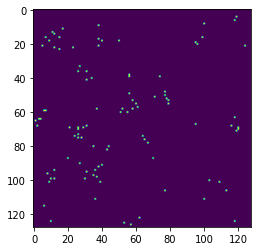

In [12]:
plt.imshow(model[-6])

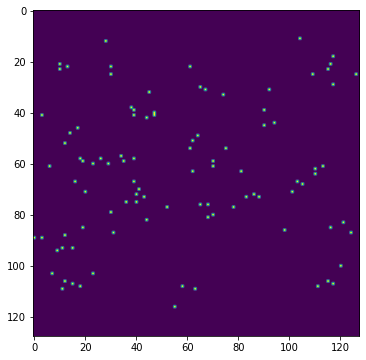

In [13]:
ani = animate_frames(model, figsize=(6,6), interval=200)
HTML(ani.to_jshtml())

In [ ]:
model.create_field()

In [ ]:
np.linalg.norm(model.points[0][:,2:], axis=-1)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(model[0])
plt.show()

In [ ]:
import numpy as np

from IPython.display import HTML

from matplotlib import animation
from matplotlib import pyplot as plt
%matplotlib inline

boid_count = 10

limits = np.array([2000, 2000])

In [ ]:
def new_flock(count, lower_limits, upper_limits):
    width = upper_limits - lower_limits
    return (lower_limits[:, np.newaxis] + np.random.rand(2, count) * width[:, np.newaxis])

def update_boids(positions, velocities):
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    square_distances = np.sum(squared_displacements, 0)
    alert_distance = 100
    far_away = square_distances > alert_distance
    separations_if_close = np.copy(separations)
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    velocities += np.sum(separations_if_close, 1)

    velocity_differences = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    formation_flying_distance = 10000
    formation_flying_strength = 0.125
    very_far = square_distances > formation_flying_distance
    velocity_differences_if_close = np.copy(velocity_differences)
    velocity_differences_if_close[0, :, :][very_far] = 0
    velocity_differences_if_close[1, :, :][very_far] = 0
    print(np.mean(velocity_differences_if_close, 1),'A', np.mean(velocity_differences_if_close, 0))
    velocities -= np.mean(velocity_differences_if_close, 1) * formation_flying_strength

    positions += velocities



def animate(frame):
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())

In [ ]:
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))

figure = plt.figure()
axes = plt.axes(xlim=(0, limits[0]), ylim=(0, limits[1]))
scatter = axes.scatter(positions[0, :], positions[1, :],
                       marker='o', edgecolor='k', lw=0.5)

anim = animation.FuncAnimation(figure, animate,
                               frames=200, interval=50)

HTML(anim.to_jshtml())

In [ ]:
pos = np.random.randint(0,100, (2,4))
x_dist, y_dist = np.abs(pos[:, np.newaxis, :] - pos[:, :, np.newaxis])
w, h = 100, 100
np.sum(np.abs(pos[:, np.newaxis, :] - pos[:, :, np.newaxis]), axis = 1)



In [21]:
coord = np.random.randint(0,10, 2)
oposite_coord = np.random.randint(0,10, 2)

w, h = 10,10

if np.abs(diff[0])>w/2:
    diff[0] -= w*np.sign(diff[0])
if np.abs(diff[1])>h/2:
     diff[1] -=  h*np.sign(diff[1])


(array([3, 4]), array([-7, -6]))

In [5]:
metric = lambda x,y: np.sqrt(np.minimum(np.abs(x[0]-y[0]), w - np.abs(x[0]-y[0]))**2 + np.minimum(np.abs(x[1]-y[1]), h - np.abs(x[1]-y[1]))**2) 

In [6]:
metric(coord,other_coord)

NameError: name 'other_coord' is not defined

In [9]:
np.array([])

IndexError: invalid index to scalar variable.